## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [107]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [108]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [109]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [110]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [111]:
df[df['converted'] == 1]['user_id'].nunique() / df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [112]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [113]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 22 to 294331
Data columns (total 5 columns):
user_id         3893 non-null int64
timestamp       3893 non-null object
group           3893 non-null object
landing_page    3893 non-null object
converted       3893 non-null int64
dtypes: int64(2), object(3)
memory usage: 182.5+ KB


f. Do any of the rows have missing values?

**Answer:** No missing values within this subset. The number of entries is identical to the number of values in all columns.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [114]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [115]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [116]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [117]:
df_duplicated = df2
df_duplicated = df_duplicated[df_duplicated.duplicated(['user_id'], keep = False)]
print(df_duplicated)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**Answer**: The user referring to the user_id 773192 has a duplicated entry in the data frame.

c. What is the row information for the repeat **user_id**? 

In [118]:
df_duplicated.index.get_values()

array([1899, 2893])

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [119]:
df2.drop_duplicates(subset='user_id', keep='first', inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [120]:
cvr = df2.query("converted== 1").count()[0]/df2['converted'].count()
cvr

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [121]:
cvr_control = df2.query("group == 'control' and converted== 1").count()[0] / df2.query("group == 'control'").count()[0]
cvr_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [122]:
cvr_experiment = df2.query("group == 'treatment' and converted== 1").count()[0] / df2.query("group == 'treatment'").count()[0]
cvr_experiment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [123]:
p_chance_old_new = df2.query("landing_page == 'new_page'").count()[0] / df2.count()[0]
p_chance_old_new

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Answer**: The probability for receiving the new respectively the old page is 50%. That in combination with the slightly higher chances for a converting user in the control group (receiving the old page) there is just little evidence that the old page leads to more conversions. However, putting the very little differences into practical perspective we can also assume, that there no difference in conversions between the old and new version of the page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$h_{0}$** = **$p_{new}$** - **$p_{old}$** <= 0 <br><br>
**$h_{0}$** = **$p_{new}$** - **$p_{old}$**  > 0 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [124]:
p_new = sum(df2.query("converted == '1'")['converted']) / df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [125]:
#Same calculation as before, since we expect in the Null-Hypothesis, that convert rate for the new page is worse or equal to the old one.
p_old = sum(df2.query("converted == '1'")['converted']) / df2.shape[0]
p_old

0.11959708724499628

In [126]:
p_new - p_old

0.0

c. What is $n_{new}$?

In [127]:
n_new = len(df2.query("group == 'treatment'"))
n_new

145310

d. What is $n_{old}$?

In [128]:
n_old = len(df2.query("group == 'control'"))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [129]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17338

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [130]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17423

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [131]:
(new_page_converted/n_new)-(old_page_converted/n_old)

-0.0006146689949831363

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [132]:
p_diffs = []

for x in range(0,10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append((new_page_converted/n_new)-(old_page_converted/n_old))

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

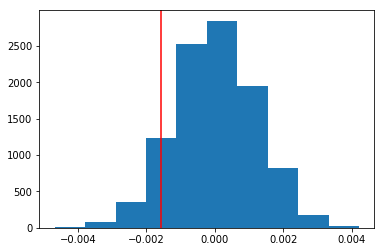

In [133]:
#Calculation the observed conversion rate for visualization. "Experiment" refers to the new page, "control" refers to the old page.
cvr_diff = cvr_experiment - cvr_control
plt.hist(p_diffs);
plt.axvline(x=cvr_diff, color="red");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [134]:
df_p_diffs = pd.DataFrame(p_diffs)
df_p_diffs.rename(index=str, columns={0:"Differences"} ,inplace=True)

df_p_diffs.query("Differences > @cvr_diff").count()/df_p_diffs['Differences'].count()

Differences    0.9127
dtype: float64

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**:
In part **j.** I calculated the p-value. The p-value describes the probability that the Null-Hypothesis is true, given the applied statistical model. The higher the value, the larger the chance that rejecting the Alternative-Hypothesis is correct. Furthermore, the p-value can be compared against the threshold-value "alpha". Alpha describes the maximum acceptable rate for type 1 errors, when deciding to accepting or rejecting the Null-Hypothesis. If the p-value is larger than the defined threshold-value alpha, we fail to reject the Null-Hypothesis.
In this case here, the p-value (0.9) of the bootstrap sample differences in conversion rate is high, given that the maximum p-value can be "1". We therefore accept the Null-Hypothesis which is, that the new page compared to the old page, performs equal or worse.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [135]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control' and converted== 1").count()[0]
convert_new = df2.query("group == 'treatment' and converted== 1").count()[0]
n_old = len(df2.query("group == 'treatment'"))
n_new = len(df2.query("group == 'control'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [136]:
# Application of this test is inspired and sourced by http://knowledgetack.com/python/statsmodels/proportions_ztest/

z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
#As the Null-Hypthesis states, the old page to be better in terms of convertion rate, I added the paratemeter "alternative='larger'"
print("z_score = " + str(z_score))
print("p_value = " + str(p_value))

z_score = -1.26169574219
p_value = 0.896470855197


In [137]:
from scipy.stats import norm

#print(norm.cdf(z_score))
# Tells us how significant the z-score is.

print(norm.ppf(1-(0.05/2)))
#Tells us what our critical value at 95% confidence is.

1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:** According to this z-test at 95% confidence interval, the z-score of -1.26 does not exceed the critical value of +/-1.96. We therefore fail to reject to the Null-Hypothesis. This goes along with the findings in parts **j.** and **k.**.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:** The appropriate type of regression in this case is the 'logistic regression'. This regression type supports datasets with only two outcome values; 1 and 0.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [138]:
#Creating a copy of the dataset for this analysis.
df5 = df2.copy()

#Adding an intercept column.
df5['intercept'] = 1

#Creating dummy variables for the landing page the user has seen.
df5[['new_page', 'old_page']] = pd.get_dummies(df['landing_page'])

#Creating dummy variables for the group the user belongs to, is not neccessary, as old_page corresponds with control-group and newapge with treatment-group.
df5.drop(['timestamp', 'group', 'landing_page', 'new_page'], axis = 1, inplace=True)
df5.rename(columns={'old_page':'ab_page'}, inplace=True)

df5.head()

,user_id,converted,intercept,ab_page
0,851104,0,1,1
1,804228,0,1,1
2,661590,0,1,0
3,853541,0,1,0
4,864975,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [139]:
import statsmodels.api as sm

In [140]:
logit_mod = sm.Logit(df5['converted'], df5[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:27:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

In [141]:
#Exponentiating coefficients for interpretation
np.exp(results.params)

intercept    0.134827
ab_page      1.015102
dtype: float64

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**Answer:** Looking at the p-value for column ab_page we see that this value is not near null. That means, the new landing page does not seem to have significant influence on the user to convert compared to the old one. Looking at the exponentiated coefficients, we can assume the following: For each unit increase in ab_page (meaning going from default '0, old page' to '1), new page' we can expect an increase in conversion by 1.015. This goes along with the insignificant p-value. Conclusion: The new page did not perform significantly better than the old page.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**Answer:** The p-value associated with ab_page is 0.190.

In part two, I calculated the p-value in a setting of a one-sided test. Going back to the hypothesis, we see that the null implies no improvement by the alternative and the alternative implies only an increase in performance measured in the difference in conversion rate. Therefore, the setting shall be seen as “one-sided” as only the direction of ‘improvement’ has been covered when stating the hypothesizes and calculating the p-value.

In part three, the setting was different, compared to part two. I applied a logistic regression, which by nature calculates the difference in conversion rate, which either can be positive or negative. The p-value covers two directions. 
When dividing the p-value of 0.190 by 2, we go near the p-value of part two: 0.95 is near 0.8965.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** Including other potential factors into the regression analysis is generally a good idea. Other factors may explain any differences in outcome better than the existing ones. You therefore may improve the results.

However, other factors make the model more complex and the correct interpretation of the results more difficult. Besides, you have higher chances for wrong results. For example, wrong results may occur in cases where the independent variables correlate with each other (multicollinearity).

Lastly, you have to test different scenarios, leaving part(s) of the independent variables out, which may on the other hand also improve results. There might be variables which do not have any impact or the relationships between the independent and dependent variables which might be as complex as you first assumed. That means a good reflection of the more dimensional analysis is vital to make the results as simple as they can be.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [142]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [143]:
#cdf2 = df2c.merge(cdf, on='user_id', how='inner')
df5_plus_countries = df_countries.merge(df5, on='user_id', how='inner')

df5_plus_countries.head()

,user_id,country,converted,intercept,ab_page
0,834778,UK,0,1,1
1,928468,US,0,1,0
2,822059,UK,1,1,0
3,711597,UK,0,1,1
4,710616,UK,0,1,0


In [144]:
df5_plus_countries['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [145]:
df5_plus_countries[['CA', 'UK', 'US']] = pd.get_dummies(df5_plus_countries['country'])
# As the order of the columns for each country matter, when creating the dummies, a quick check.
# ab_page = 1 implies --> user belongs to the control group and has seen the old page.

df5_plus_countries.drop('country', axis = 1)

df5_plus_countries.head(10)

,user_id,country,converted,intercept,ab_page,CA,UK,US
0,834778,UK,0,1,1,0,1,0
1,928468,US,0,1,0,0,0,1
2,822059,UK,1,1,0,0,1,0
3,711597,UK,0,1,1,0,1,0
4,710616,UK,0,1,0,0,1,0
5,909908,UK,0,1,0,0,1,0
6,811617,US,1,1,0,0,0,1
7,938122,US,1,1,0,0,0,1
8,887018,US,0,1,0,0,0,1
9,820683,US,0,1,0,0,0,1


In [146]:
logit_mod_country = sm.Logit(df5_plus_countries['converted'], df5_plus_countries[['intercept', 'UK', 'US']])
# Leaving 'CA'-column out, as this the value with the least amount of entries in the dataset.
results_country = logit_mod_country.fit()
results_country.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:               1.521e-05
Time:                        13:27:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [147]:
#Exponentiating coefficients for interpretation
np.exp(results_country.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

**Answer:** The p-values for the used independent variables are all above 0.05, which suggests insignificant relationships towards the dependent variable “converted”. We therefore fail to reject the Null-Hypothesis: According to this result the new landing page does not perform significantly better and the old one, also not when segmenting the users per country.
The exponentiated coefficients speak the same language. When reading the results, it tells that for each unit increase in the value:
<ul>
<li>UK, meaning the user is from the country UK, he is 1.052 times more likely to convert, holding all other variables constant;</li>
<li>US, meaning the user is from the country US, he is 1.042 times more likely to convert, holding all other variables constant.</li>
</ul>

Conclusion: The country where the user lives, does have significant influence on the likelihood for converting.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [148]:
logit_mod_country_page = sm.Logit(df5_plus_countries['converted'], df5_plus_countries[['intercept', 'ab_page','UK', 'US']])
# Leaving 'CA'-column out, as this the value with the least amount of entries in the dataset.
results_country_page = logit_mod_country_page.fit()
results_country_page.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:               2.323e-05
Time:                        13:27:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0450      0.027    -76.820      0.000      -2.097      -1.993
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Answer:** The p-values of the independent variables ab_page, UK and US in this combined setting do not exceed the 95% significance interval as they are higher than 0.05. That means, none of these variables appear to have significant influence  on the dependent variable converted.

In [149]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0